# Overview of this jupyter notebook

1. Loading data
2. Transforming data (normalization, shuffle)
3. Loading optimized model architecture
4. Hyperparameter Optimization with Grid Search 5 Fold Cross Validation
    - Optimizing training specific hyperparameters
    - Optimizing model specific hyperparameters
5. Final Evaluation

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, cross_validate
from sklearn.model_selection import cross_val_predict
import pickle
import json
from tqdm.notebook import tqdm_notebook as tq
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, clone_model, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adamax
import keras_tuner as kt

In [1]:
import os
import importlib
from library import etl_data as etl            # this module contains functions that load, visualize and save the data
from library import faps_color as fapsc        # this module contains the color combination of FAPS Institute
from library import classification_util as cu  # this module contains helper functions for the classification task
print(importlib.reload(etl))
print(importlib.reload(fapsc))
print(importlib.reload(cu))

<module 'library.etl_data' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\etl_data.py'>
<module 'library.faps_color' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\faps_color.py'>
<module 'library.classification_util' from 'C:\\Users\\songs\\OneDrive\\Desktop\\0. PA_FAPS\\04_Code\\library\\classification_util.py'>


In [4]:
# GPU check

if len(tf.config.list_physical_devices('GPU')) > 0:
    print("TensorFlow version: ", tf.__version__)
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    print("Name: ", tf.test.gpu_device_name())
else:
    print("TensorFlow version: ", tf.__version__)
    print("GPU is not available")

TensorFlow version:  2.8.0
Num GPUs Available:  1
Name:  /device:GPU:0


## 1. Loading data

In [5]:
classes = ['0_in_ordnung',
           '1_kleine_durchgangsbohrung',
           '2_versetzte_fuegepartner',
           '3_unebene_fuegeflaeche',
           '4_span_im_gewinde',
           '5_verschmutzte_schraube',
           '6_fremdkoerper_am_gewindeende',
           '7_beschaedigte_schraube']

In [6]:
df0 = pd.read_pickle("dataframes/df0_v4.1.pkl")
df1 = pd.read_pickle("dataframes/df1_v4.1.pkl")
df2 = pd.read_pickle("dataframes/df2_v4.1.pkl")
df3 = pd.read_pickle("dataframes/df3_v4.1.pkl")
df4 = pd.read_pickle("dataframes/df4_v4.1.pkl")
df5 = pd.read_pickle("dataframes/df5_v4.1.pkl")
df6 = pd.read_pickle("dataframes/df6_v4.1.pkl")
df7 = pd.read_pickle("dataframes/df7_v4.1.pkl")

In [7]:
df0 = df0[df0.columns[:200]]
df0.shape

(775, 200)

In [8]:
df_list = [df0, df1, df2, df3, df4, df5, df6, df7]

In [9]:
feature = np.load('feature_label/feature_single_v4.1.npy')
feature.shape

(1600, 920)

In [10]:
label = np.load("feature_label/label_single_v4.1.npy")
label = to_categorical(label)
label.shape

(1600, 8)

## 2. Transforming data (normalization, shuffle)

In [11]:
# normalize the fature by dividing max value of feature

max_feat = np.max(feature)
feature_scaled = feature / max_feat

print(max_feat, feature_scaled.shape)

2.56704 (1600, 920)


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(feature_scaled, label, random_state=13, test_size=0.25, shuffle=True)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_test)

(1200, 920)
(1200, 8)
(400, 920)
(400, 8)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [13]:
x_train_inverse = x_train*max_feat
x_test_inverse = x_test*max_feat

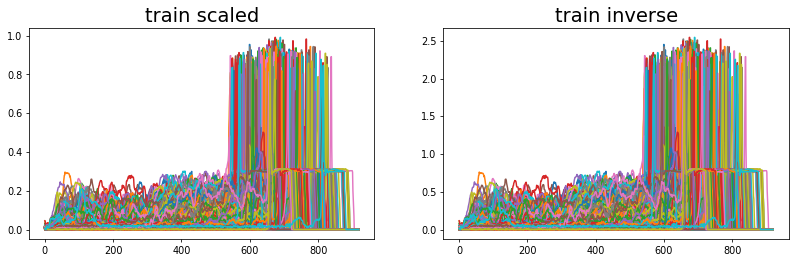

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=70)
axs[0].plot(x_train.transpose())
axs[1].plot(x_train_inverse.transpose())

axs[0].set_title("train scaled", fontsize=20)
axs[1].set_title("train inverse", fontsize=20)
fig.show()

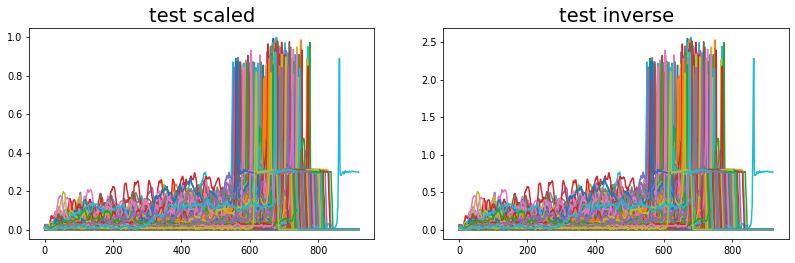

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(14,4), dpi=70)
axs[0].plot(x_test.transpose())
axs[1].plot(x_test_inverse.transpose())

axs[0].set_title("test scaled", fontsize=20)
axs[1].set_title("test inverse", fontsize=20)
fig.show()

In [16]:
y_test_converted = np.argmax(y_test, axis=1)
y_test_converted

array([4, 6, 2, 4, 4, 7, 0, 7, 0, 1, 0, 5, 3, 2, 5, 7, 7, 4, 4, 7, 7, 3,
       3, 0, 2, 0, 0, 5, 4, 6, 7, 4, 2, 6, 6, 2, 1, 0, 0, 6, 4, 7, 6, 3,
       6, 6, 3, 6, 2, 5, 3, 7, 6, 6, 6, 4, 2, 5, 5, 7, 1, 0, 5, 3, 4, 2,
       0, 3, 7, 2, 6, 0, 6, 2, 3, 6, 1, 7, 6, 3, 5, 4, 6, 4, 4, 5, 7, 4,
       3, 1, 6, 1, 5, 2, 5, 3, 1, 3, 7, 4, 3, 6, 7, 6, 6, 7, 4, 6, 4, 2,
       7, 6, 1, 4, 3, 2, 1, 4, 4, 4, 6, 3, 0, 2, 7, 6, 3, 3, 1, 7, 1, 1,
       0, 1, 1, 0, 4, 0, 4, 5, 2, 7, 5, 7, 1, 6, 2, 0, 2, 3, 4, 5, 1, 1,
       7, 3, 3, 5, 5, 2, 1, 0, 2, 0, 6, 5, 3, 1, 3, 0, 2, 3, 2, 6, 1, 3,
       5, 1, 7, 5, 6, 4, 4, 5, 0, 2, 6, 4, 1, 3, 0, 1, 2, 4, 7, 4, 4, 7,
       2, 4, 4, 4, 5, 4, 7, 2, 4, 2, 5, 6, 3, 2, 3, 5, 5, 0, 1, 2, 1, 2,
       7, 0, 6, 3, 2, 3, 1, 1, 7, 4, 1, 6, 4, 7, 1, 6, 4, 0, 1, 3, 6, 6,
       6, 0, 5, 6, 2, 0, 0, 0, 5, 4, 2, 4, 4, 5, 3, 5, 6, 1, 3, 5, 4, 3,
       6, 6, 7, 6, 1, 2, 4, 0, 7, 1, 6, 2, 7, 6, 3, 6, 0, 3, 0, 7, 5, 4,
       2, 4, 5, 0, 2, 6, 1, 3, 4, 1, 7, 4, 2, 0, 0,

In [17]:
unique, counts = np.unique(y_test_converted, return_counts=True)
dict(zip(unique, counts))

{0: 50, 1: 46, 2: 45, 3: 53, 4: 62, 5: 46, 6: 57, 7: 41}

In [18]:
# reshape train data in 3 dimensinal shape
len_curve = feature.shape[1]
print(len_curve)

x_train = x_train.reshape(-1, len_curve, 1)
x_test = x_test.reshape(-1, len_curve, 1)
print(x_train.shape)
print(x_test.shape)

920
(1200, 920, 1)
(400, 920, 1)


## 3. Loading optimized model architecture

In [19]:
cnn_struc = {"conv":3, "maxpool":[1,1,1,1], "bn_conv":[0,1,0,0], "dropout_conv":[0,0,0,0], 
             "dense":2, "bn_dense":[0,0,0,0], "dropout_dense":[0,0,0,0]}

In [20]:
model = cu.cnn_structure(cnn_struc["conv"], cnn_struc["maxpool"], cnn_struc["bn_conv"], cnn_struc["dropout_conv"],
                         cnn_struc["dense"], cnn_struc["bn_dense"], cnn_struc["dropout_dense"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 913, 32)           288       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 304, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 297, 32)           8224      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 32)           0         
 1D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 99, 32)           128       
 ormalization)                                                   
                                                        

## 4. Hyperparameter Optimization with 5 Fold Cross Validation

### 4.1 Optimizing training specific hyperparameters

In [29]:
x_train.shape

(1200, 920, 1)

In [30]:
def model_cnn_cv1(learning_rate, optimizer):
            
    model = Sequential()
    
    model.add(Conv1D(32, 8, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(3))
    model.add(Conv1D(32, 8, activation="relu"))
    model.add(MaxPooling1D(3))
    
    model.add(BatchNormalization())
    
    model.add(Conv1D(32, 8, activation="relu"))
    model.add(MaxPooling1D(3))

    model.add(Flatten())
    
    model.add(Dense(80, activation="relu"))
    model.add(Dense(80, activation="relu"))
    model.add(Dense(8, activation="softmax"))
    
    model.compile(optimizer=optimizer(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [32]:
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01]
batch_size = [2, 4, 10, 32, 64]
epochs = [35, 40, 45, 50, 55]
optimizer = [Adam, RMSprop, Adamax]

param_grid1 = dict(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs, optimizer=optimizer)
param_grid1

{'learning_rate': [0.0001, 0.0005, 0.001, 0.005, 0.01],
 'batch_size': [2, 4, 10, 32, 64],
 'epochs': [35, 40, 45, 50, 55],
 'optimizer': [tensorflow.python.keras.optimizer_v2.adam.Adam,
  tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop,
  tensorflow.python.keras.optimizer_v2.adamax.Adamax]}

In [ ]:
model1 = KerasClassifier(build_fn=model_cnn_cv1)

clf1 = GridSearchCV(estimator=model1, param_grid=param_grid1, cv=5, refit=True, verbose=10) #scoring_default -> accuracy
result1 = clf1.fit(x_train, y_train)

print(result1.best_score_, result1.best_params_)
df_result1 = pd.DataFrame(result1.cv_results_)
df_result1.to_pickle("results/cnn_cv1_v4.1_fapspc.pkl")  # results saved as dataframe

In [34]:
result1.best_score_, result1.best_params_

(0.9775000095367432,
 {'batch_size': 4,
  'epochs': 40,
  'learning_rate': 0.005,
  'optimizer': tensorflow.python.keras.optimizer_v2.adamax.Adamax})

In [63]:
opt_str = []

for opt in df_result1["param_optimizer"]:
    opt_str.append(str(opt).split(".")[-1][:-2])

In [64]:
#df_result1.insert(6, "param_opt", opt_str)

In [66]:
#df_result1.to_pickle("results/cnn_cv1_v4.1_fapspc.pkl")

In [35]:
df_result1 = pd.read_pickle("results/cnn_cv1_v4.1_fapspc.pkl")

In [36]:
df_result1

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_opt,param_learning_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,45.174978,1.008231,0.375215,0.047285,2,35,Adam,0.0001,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 2, 'epochs': 35, 'learning_rate...",0.958333,0.962500,0.979167,0.979167,0.983333,0.972500,0.010069,56
1,50.182151,0.809511,0.388868,0.090530,2,35,RMSprop,0.0001,<class 'tensorflow.python.keras.optimizer_v2.r...,"{'batch_size': 2, 'epochs': 35, 'learning_rate...",0.954167,0.970833,0.979167,0.983333,0.975000,0.972500,0.010069,49
2,45.142251,0.410617,0.354521,0.024713,2,35,Adamax,0.0001,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 2, 'epochs': 35, 'learning_rate...",0.954167,0.958333,0.970833,0.962500,0.975000,0.964167,0.007728,197
3,44.298690,0.694679,0.341632,0.007805,2,35,Adam,0.0005,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 2, 'epochs': 35, 'learning_rate...",0.970833,0.979167,0.979167,0.962500,0.966667,0.971667,0.006667,78
4,50.285957,0.930228,0.348017,0.011135,2,35,RMSprop,0.0005,<class 'tensorflow.python.keras.optimizer_v2.r...,"{'batch_size': 2, 'epochs': 35, 'learning_rate...",0.950000,0.962500,0.979167,0.970833,0.975000,0.967500,0.010341,154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,4.422751,0.019278,0.164629,0.003292,64,55,RMSprop,0.005,<class 'tensorflow.python.keras.optimizer_v2.r...,"{'batch_size': 64, 'epochs': 55, 'learning_rat...",0.941667,0.937500,0.962500,0.825000,0.912500,0.915833,0.048117,316
371,3.906325,0.017310,0.166592,0.001757,64,55,Adamax,0.005,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 64, 'epochs': 55, 'learning_rat...",0.966667,0.970833,0.975000,0.970833,0.966667,0.970000,0.003118,115
372,3.787374,0.044131,0.173609,0.006014,64,55,Adam,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 64, 'epochs': 55, 'learning_rat...",0.908333,0.970833,0.966667,0.966667,0.979167,0.958333,0.025413,243
373,4.353703,0.021366,0.168695,0.004130,64,55,RMSprop,0.01,<class 'tensorflow.python.keras.optimizer_v2.r...,"{'batch_size': 64, 'epochs': 55, 'learning_rat...",0.954167,0.916667,0.941667,0.966667,0.737500,0.903333,0.084549,324


In [37]:
df_result1[df_result1.rank_test_score==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_opt,param_learning_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
101,25.601604,0.238341,0.242112,0.002270,4,40,Adamax,0.005,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 4, 'epochs': 40, 'learning_rate...",0.962500,0.983333,0.983333,0.979167,0.979167,0.9775,0.007728,1
284,5.183188,0.079604,0.165957,0.005042,32,50,Adamax,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 32, 'epochs': 50, 'learning_rat...",0.966667,0.975000,0.987500,0.983333,0.975000,0.9775,0.007265,1


In [38]:
df_result1[df_result1.rank_test_score==3]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_opt,param_learning_rate,param_optimizer,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
299,6.043957,0.03585,0.169231,0.004897,32,55,Adamax,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,"{'batch_size': 32, 'epochs': 55, 'learning_rat...",0.975,0.975,0.979167,0.979167,0.975,0.976667,0.002041,3


In [39]:
top_acc1 = [df_result1.iloc[df_result1[df_result1.rank_test_score==1].index[0]]["mean_test_score"],
            df_result1.iloc[df_result1[df_result1.rank_test_score==1].index[1]]["mean_test_score"],
            df_result1.iloc[df_result1[df_result1.rank_test_score==3].index[0]]["mean_test_score"]]
top_acc1 = np.round(top_acc1, 3)
top_acc1

array([0.978, 0.978, 0.977])

In [40]:
rank1 = df_result1[df_result1.rank_test_score==1][["param_batch_size", "param_epochs", "param_opt", "param_learning_rate"
                                                  ]].values.transpose()

In [41]:
rank2 = df_result1[df_result1.rank_test_score==2][["param_batch_size", "param_epochs", "param_opt", "param_learning_rate"
                                                  ]].values.transpose()

In [42]:
rank3 = df_result1[df_result1.rank_test_score==3][["param_batch_size", "param_epochs", "param_opt", "param_learning_rate"
                                                  ]].values.transpose()

In [43]:
ranking1 = np.concatenate((rank1, rank2, rank3), axis=1)
ranking1

array([[4, 32, 32],
       [40, 50, 55],
       ['Adamax', 'Adamax', 'Adamax'],
       [0.005, 0.01, 0.01]], dtype=object)

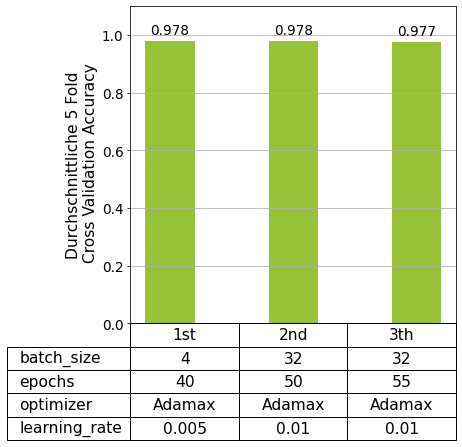

In [44]:
x_position = np.arange(3) + 0.5 # the label, bar locations
    
plt.figure(figsize=(6, 6), dpi=70)
rects = plt.bar(x_position, top_acc1, width=0.4, color=fapsc.green)
plt.bar_label(rects, padding=4, fontsize=14)
plt.xticks([])
plt.ylim(0, 1.1)
plt.ylabel(f"Durchschnittliche 5 Fold\n Cross Validation Accuracy", fontsize=16)
plt.yticks(fontsize=14)

table = plt.table(cellText = ranking1,
                  cellLoc='center',
                     colLabels=["1st", "2nd", "3th"],
                     rowLabels=["batch_size", "epochs", "optimizer", "learning_rate"],
                     loc='bottom')
table.set_fontsize(16)
table.scale(1, 2)
plt.grid()
plt.show()

### 4.2 Optimizing model specific hyperparameters

In [19]:
x_train.shape

(1200, 920, 1)

In [20]:
def model_cnn_cv2(filters, kernel, maxpool, dense1, dense2):
            
    model = Sequential()
    
    model.add(Conv1D(filters, kernel, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(maxpool))
    
    model.add(Conv1D(filters, kernel, activation="relu"))
    model.add(MaxPooling1D(maxpool))
    
    model.add(BatchNormalization())
    
    model.add(Conv1D(filters, kernel, activation="relu"))
    model.add(MaxPooling1D(maxpool))

    model.add(Flatten())
    
    model.add(Dense(dense1, activation="relu"))
    model.add(Dense(dense2, activation="relu"))
    model.add(Dense(8, activation="softmax"))
    
    model.compile(optimizer=Adamax(learning_rate=0.005), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [21]:
filters = [8, 16, 32, 48]
kernel = [2, 4, 8, 16]
maxpool = [2, 3]
dense1 = [40, 80, 120, 160, 200]
dense2 = [20, 40, 60, 80, 100]

In [22]:
param_grid2 = dict(filters=filters, kernel=kernel, maxpool=maxpool, dense1=dense1, dense2=dense2)
param_grid2

{'filters': [8, 16, 32, 48],
 'kernel': [2, 4, 8, 16],
 'maxpool': [2, 3],
 'dense1': [40, 80, 120, 160, 200],
 'dense2': [20, 40, 60, 80, 100]}

In [ ]:
model2 = KerasClassifier(build_fn=model_cnn_cv2, epochs=40, batch_size=4)

clf2 = GridSearchCV(estimator=model2, param_grid=param_grid2, cv=5, refit=True, verbose=10) #scoring_default -> accuracy
result2 = clf2.fit(x_train, y_train)

print(result2.best_score_, result2.best_params_)
df_result2 = pd.DataFrame(result2.cv_results_)
df_result2.to_pickle("results/cnn_cv2_v4.1_fapspc.pkl")

In [24]:
print(result2.best_score_, result2.best_params_)

0.9791666865348816 {'dense1': 200, 'dense2': 40, 'filters': 48, 'kernel': 8, 'maxpool': 3}


In [45]:
df_result2 = pd.read_pickle("results/cnn_cv2_v4.1_fapspc.pkl")
df_result2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dense1,param_dense2,param_filters,param_kernel,param_maxpool,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,26.102483,1.647214,0.244862,0.014291,40,20,8,2,2,"{'dense1': 40, 'dense2': 20, 'filters': 8, 'ke...",0.933333,0.962500,0.941667,0.958333,0.970833,0.953333,0.013794,739
1,24.913390,0.173631,0.237463,0.004611,40,20,8,2,3,"{'dense1': 40, 'dense2': 20, 'filters': 8, 'ke...",0.958333,0.970833,0.970833,0.966667,0.954167,0.964167,0.006770,506
2,25.114005,0.191045,0.240869,0.002399,40,20,8,4,2,"{'dense1': 40, 'dense2': 20, 'filters': 8, 'ke...",0.954167,0.950000,0.958333,0.970833,0.945833,0.955833,0.008580,703
3,25.008964,0.089486,0.283830,0.086791,40,20,8,4,3,"{'dense1': 40, 'dense2': 20, 'filters': 8, 'ke...",0.958333,0.975000,0.966667,0.970833,0.983333,0.970833,0.008333,157
4,25.272825,0.133497,0.241835,0.003653,40,20,8,8,2,"{'dense1': 40, 'dense2': 20, 'filters': 8, 'ke...",0.950000,0.958333,0.975000,0.954167,0.975000,0.962500,0.010541,567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,27.153616,0.054286,0.250931,0.003380,200,100,48,4,3,"{'dense1': 200, 'dense2': 100, 'filters': 48, ...",0.966667,0.987500,0.983333,0.979167,0.979167,0.979167,0.006972,2
796,29.441958,0.197323,0.252324,0.006090,200,100,48,8,2,"{'dense1': 200, 'dense2': 100, 'filters': 48, ...",0.958333,0.966667,0.983333,0.958333,0.966667,0.966667,0.009129,413
797,27.599886,0.164440,0.249626,0.005227,200,100,48,8,3,"{'dense1': 200, 'dense2': 100, 'filters': 48, ...",0.954167,0.966667,0.979167,0.979167,0.966667,0.969167,0.009354,273
798,28.860685,0.284780,0.249633,0.005088,200,100,48,16,2,"{'dense1': 200, 'dense2': 100, 'filters': 48, ...",0.950000,0.966667,0.979167,0.975000,0.975000,0.969167,0.010408,243


In [50]:
df_result2[df_result2.rank_test_score==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dense1,param_dense2,param_filters,param_kernel,param_maxpool,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
701,26.215649,0.23061,0.244835,0.004645,200,40,48,8,3,"{'dense1': 200, 'dense2': 40, 'filters': 48, '...",0.970833,0.983333,0.983333,0.983333,0.975,0.979167,0.00527,1


In [51]:
df_result2[df_result2.rank_test_score==2]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dense1,param_dense2,param_filters,param_kernel,param_maxpool,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,24.808642,0.175442,0.241073,0.005501,40,20,32,2,3,"{'dense1': 40, 'dense2': 20, 'filters': 32, 'k...",0.958333,0.983333,0.987500,0.983333,0.983333,0.979167,0.010541,2
795,27.153616,0.054286,0.250931,0.003380,200,100,48,4,3,"{'dense1': 200, 'dense2': 100, 'filters': 48, ...",0.966667,0.987500,0.983333,0.979167,0.979167,0.979167,0.006972,2


In [ ]:
top_acc1 = [df_result1.iloc[df_result1[df_result1.rank_test_score==1].index[0]]["mean_test_score"],
            df_result1.iloc[df_result1[df_result1.rank_test_score==1].index[1]]["mean_test_score"],
            df_result1.iloc[df_result1[df_result1.rank_test_score==3].index[0]]["mean_test_score"]]
top_acc1 = np.round(top_acc1, 3)
top_acc1

## 5. Final Evaluation

In [1]:
def final_model():
            
    model = Sequential()
    
    model.add(Conv1D(48, 8, activation="relu", input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(MaxPooling1D(3))
    
    model.add(Conv1D(48, 8, activation="relu"))
    model.add(MaxPooling1D(3))
    
    model.add(BatchNormalization())
    
    model.add(Conv1D(48, 8, activation="relu"))
    model.add(MaxPooling1D(3))

    model.add(Flatten())
    
    model.add(Dense(200, activation="relu"))
    model.add(Dense(40, activation="relu"))
    model.add(Dense(8, activation="softmax"))
    
    model.compile(optimizer=Adamax(learning_rate=0.005), loss="categorical_crossentropy", metrics=["accuracy"])

    return model

In [72]:
cnn_model = final_model()
cnn_model.summary()

Model: "sequential_4006"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12009 (Conv1D)        (None, 913, 48)           432       
_________________________________________________________________
max_pooling1d_12009 (MaxPool (None, 304, 48)           0         
_________________________________________________________________
conv1d_12010 (Conv1D)        (None, 297, 48)           18480     
_________________________________________________________________
max_pooling1d_12010 (MaxPool (None, 99, 48)            0         
_________________________________________________________________
batch_normalization_4003 (Ba (None, 99, 48)            192       
_________________________________________________________________
conv1d_12011 (Conv1D)        (None, 92, 48)            18480     
_________________________________________________________________
max_pooling1d_12011 (MaxPool (None, 30, 48)        

In [73]:
history = cnn_model.fit(x_train, y_train, epochs=40, batch_size=4, validation_split=0.2)

Epoch 1/40
240/240 [==============================] - 1s 4ms/step - loss: 0.6675 - accuracy: 0.7677 - val_loss: 1.0979 - val_accuracy: 0.7667
Epoch 2/40
240/240 [==============================] - 1s 3ms/step - loss: 0.2225 - accuracy: 0.9312 - val_loss: 0.2918 - val_accuracy: 0.9542
Epoch 3/40
240/240 [==============================] - 1s 3ms/step - loss: 0.1425 - accuracy: 0.9521 - val_loss: 0.2105 - val_accuracy: 0.9292
Epoch 4/40
240/240 [==============================] - 1s 3ms/step - loss: 0.1447 - accuracy: 0.9531 - val_loss: 0.1329 - val_accuracy: 0.9583
Epoch 5/40
240/240 [==============================] - 1s 3ms/step - loss: 0.0982 - accuracy: 0.9656 - val_loss: 0.2262 - val_accuracy: 0.9292
Epoch 6/40
240/240 [==============================] - 1s 3ms/step - loss: 0.0929 - accuracy: 0.9688 - val_loss: 0.2122 - val_accuracy: 0.9292
Epoch 7/40
240/240 [==============================] - 1s 3ms/step - loss: 0.1113 - accuracy: 0.9698 - val_loss: 0.1387 - val_accuracy: 0.9458
Epoch 

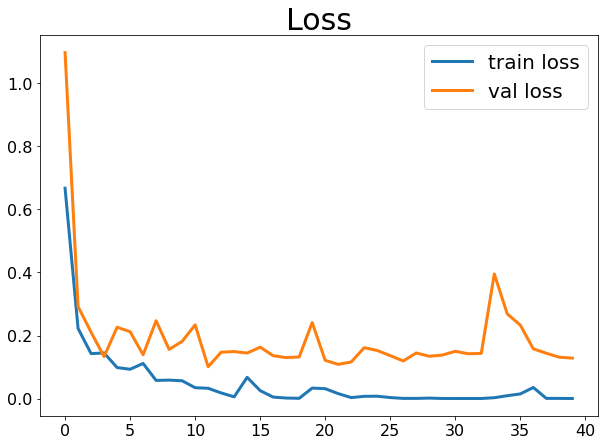

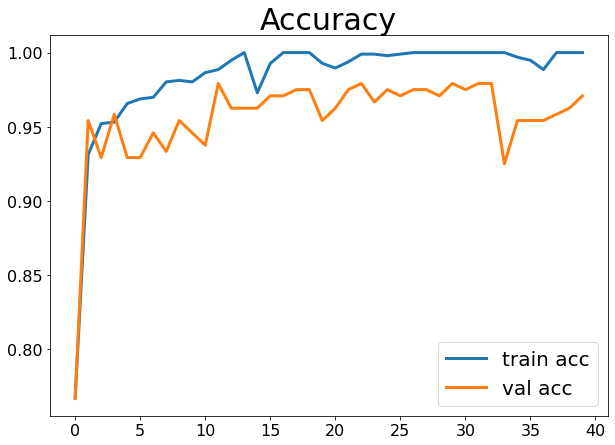

In [74]:
cu.plot_loss_acc(history)

In [21]:
loaded_model = tf.keras.models.load_model('model/1d_cnn_model_v4.1.h5')
loaded_model.summary()

Model: "sequential_4006"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12009 (Conv1D)       (None, 913, 48)           432       
                                                                 
 max_pooling1d_12009 (MaxPoo  (None, 304, 48)          0         
 ling1D)                                                         
                                                                 
 conv1d_12010 (Conv1D)       (None, 297, 48)           18480     
                                                                 
 max_pooling1d_12010 (MaxPoo  (None, 99, 48)           0         
 ling1D)                                                         
                                                                 
 batch_normalization_4003 (B  (None, 99, 48)           192       
 atchNormalization)                                              
                                                   

In [22]:
loaded_model.evaluate(x_test, y_test)

13/13 [==============================] - 8s 23ms/step - loss: 0.0852 - accuracy: 0.9800


[0.08518501371145248, 0.9800000190734863]

In [23]:
y_pred = np.argmax(loaded_model.predict(x_test), axis=-1)
y_pred

array([4, 6, 2, 4, 4, 7, 0, 7, 0, 1, 0, 5, 3, 2, 5, 7, 7, 4, 4, 7, 7, 3,
       3, 0, 2, 0, 0, 5, 4, 6, 7, 4, 2, 6, 6, 2, 1, 0, 0, 6, 4, 7, 6, 3,
       6, 6, 3, 6, 2, 5, 3, 7, 6, 6, 6, 4, 2, 4, 5, 7, 1, 0, 5, 3, 4, 2,
       0, 3, 7, 2, 4, 0, 6, 2, 3, 6, 1, 7, 6, 3, 5, 4, 6, 4, 4, 5, 7, 4,
       3, 1, 6, 1, 5, 2, 5, 3, 1, 3, 7, 4, 3, 6, 7, 6, 6, 7, 4, 6, 4, 2,
       7, 6, 1, 2, 3, 2, 1, 4, 4, 4, 6, 3, 0, 2, 7, 6, 3, 3, 1, 7, 1, 1,
       0, 1, 1, 0, 4, 0, 4, 5, 2, 7, 5, 7, 1, 6, 2, 0, 2, 3, 4, 5, 1, 1,
       7, 3, 3, 5, 5, 2, 1, 0, 2, 0, 6, 5, 3, 1, 3, 0, 2, 3, 2, 6, 1, 3,
       5, 4, 7, 5, 6, 4, 4, 5, 0, 2, 6, 4, 1, 3, 0, 1, 2, 4, 7, 4, 4, 7,
       2, 4, 4, 4, 5, 4, 7, 2, 4, 2, 5, 6, 3, 2, 3, 5, 5, 0, 1, 2, 1, 2,
       7, 0, 6, 3, 2, 3, 1, 1, 7, 7, 1, 6, 4, 7, 1, 6, 4, 0, 1, 3, 6, 6,
       6, 0, 5, 6, 2, 0, 0, 0, 5, 4, 2, 7, 4, 5, 3, 5, 6, 1, 3, 5, 4, 3,
       6, 6, 7, 6, 1, 2, 4, 0, 7, 1, 6, 2, 7, 6, 3, 6, 0, 3, 0, 7, 5, 4,
       2, 7, 5, 0, 2, 6, 1, 3, 4, 1, 7, 4, 2, 0, 0,

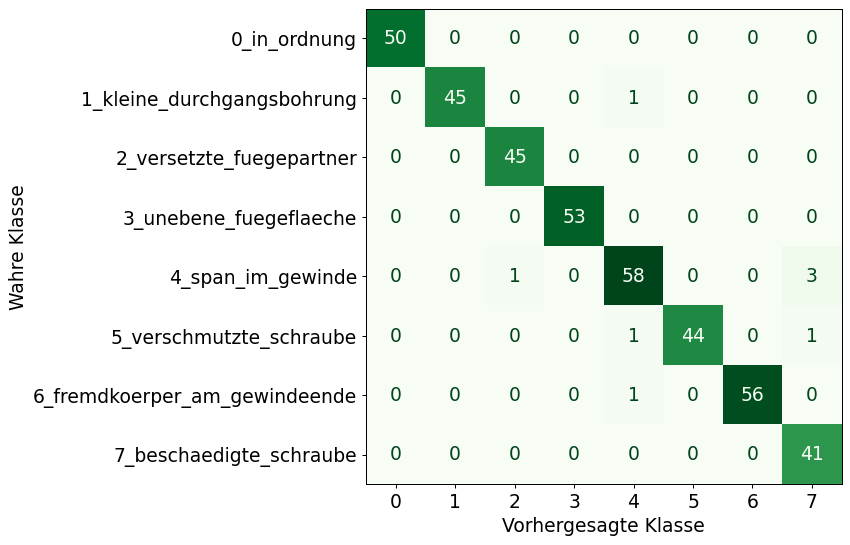

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.98      0.99        46
           2       0.98      1.00      0.99        45
           3       1.00      1.00      1.00        53
           4       0.95      0.94      0.94        62
           5       1.00      0.96      0.98        46
           6       1.00      0.98      0.99        57
           7       0.91      1.00      0.95        41

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



In [25]:
cu.plot_calc_cm(y_test_converted, y_pred, classes, dpi=90)

In [78]:
#cnn_model.save('model/1d_cnn_model_v4.1.h5')